# Sadržaj

1. [Faza 1: Analiza podataka](#Faza1-Analiza-podataka)
2. [Faza 2: Pipeline za treniranje, validaciju i testiranje modela](#Faza2-Pipeline-za-treniranje-validaciju-i-testiranje-modela)

    2.1. [Trening i validacija](#Trening-i-validacija)
    
    2.2. [Testiranje](#Testiranje)


O projektu: Cilj projekta je treniranje modela da uspešno predviđa rasu psa na osnovu unete slike.  

### **Faza1**: Analiza podataka

Analiza podataka će omogućiti razumevanje skupa podataka koji će se koristiti za treniranje modela veštačke inteligencije. Ova faza biće realizovana u nekoliko koraka.

Skup podataka je preuzet sa [Dog Breeds Image Dataset on Kaggle](https://www.kaggle.com/datasets/darshanthakare/dog-breeds-image-dataset) i sačuvan je u folderu projekta na putanji data/DogBreedsImageDataset

Sve korišćene biblioteke navedene su u prvoj Code ćeliji 

In [234]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import seaborn as sns
import numpy as np
from matplotlib import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import accuracy_score
import shutil
from collections import Counter
import time
import cv2
from sklearn.metrics import confusion_matrix
from safetensors.torch import save_file, load_file
import torch.nn.functional as F
from tqdm import tqdm

Prebrojavanje koliko klasa (rasa) se nalazi u skupu podataka.


In [235]:
data_root = Path("data/DogBreedsImageDataset")
classes = [p for p in data_root.iterdir() if p.is_dir()]
print("Broj rasa:", len(classes))

Broj rasa: 124


Ukupan broj slika u skupu podataka.

In [236]:
image_count = len(list(data_root.glob('*/*.jpg')))
print("Ukupno slika:", image_count)

Ukupno slika: 17391


Provera da li je neki od foldera prazan.

In [237]:
empty_classes = []

for cls in classes:
    cls_path = cls
    count = len([f for f in cls_path.iterdir() if f.suffix.lower() == '.jpg'])
    if count == 0:
        empty_classes.append(cls_path.name)

if empty_classes:
    print("Prazni folderi (nema slika):")
    for cls in empty_classes:
        print(cls)
else:
    print("Nema praznih foldera. Sve klase imaju slike.")

Nema praznih foldera. Sve klase imaju slike.


Izračunati su broj klasa (rasa) i ukupan broj slika. Sada se računa broj slika po klasama. 

In [238]:
print("Broj slika po klasama:")

image_per_class=[]
for cls in classes:
    cls_path = cls  
    count = len([f for f in cls_path.iterdir() if f.suffix.lower() == '.jpg'])
    image_per_class.append(count)
    print(f"{cls_path.name}: {count} slika")
    


Broj slika po klasama:
affenpinscher: 134 slika
afghan_hound: 125 slika
african: 169 slika
airedale: 189 slika
american_terrier: 153 slika
appenzeller: 135 slika
australian_cattledog: 18 slika
australian_terrier: 181 slika
basenji: 170 slika
basset_hound: 149 slika
beagle: 172 slika
bedlington_terrier: 148 slika
bernese_mountain: 190 slika
bichon_frise: 11 slika
blenheim_spaniel: 157 slika
blood_hound: 135 slika
bluetick: 147 slika
border_collie: 155 slika
border_terrier: 147 slika
borzoi: 107 slika
boston_bulldog: 173 slika
bouvier: 119 slika
boxer: 149 slika
brabancon: 141 slika
briard: 136 slika
brittany_spaniel: 136 slika
bull_mastiff: 137 slika
cairn_terrier: 177 slika
cardigan_corgi: 132 slika
caucasian_ovcharka: 30 slika
chesapeake_retriever: 142 slika
chihuahua: 129 slika
chow: 183 slika
clumber: 116 slika
cockapoo: 16 slika
cocker_spaniel: 174 slika
coonhound: 130 slika
curly_retriever: 129 slika
dachshund: 31 slika
dandie_terrier: 148 slika
dhole: 150 slika
dingo: 148 slika
d

Na osnovu prethodno izračunate vrednosti image_per_class moguće je videti i prosečan broj slika po klasama. 

In [239]:
avg_images = np.mean(image_per_class)
print(f"Prosečan broj slika po klasi: {avg_images:.2f}")

Prosečan broj slika po klasi: 140.25


Ove podatke je moguće vizuelizovati. Koristi se *import matplotlib.pyplot as plt* za kreiranje horizontalnog bar grafa (<span style="color:pink">barh</span>). Rase su poređane abecedno, kako su i navedene u skupu podataka. 

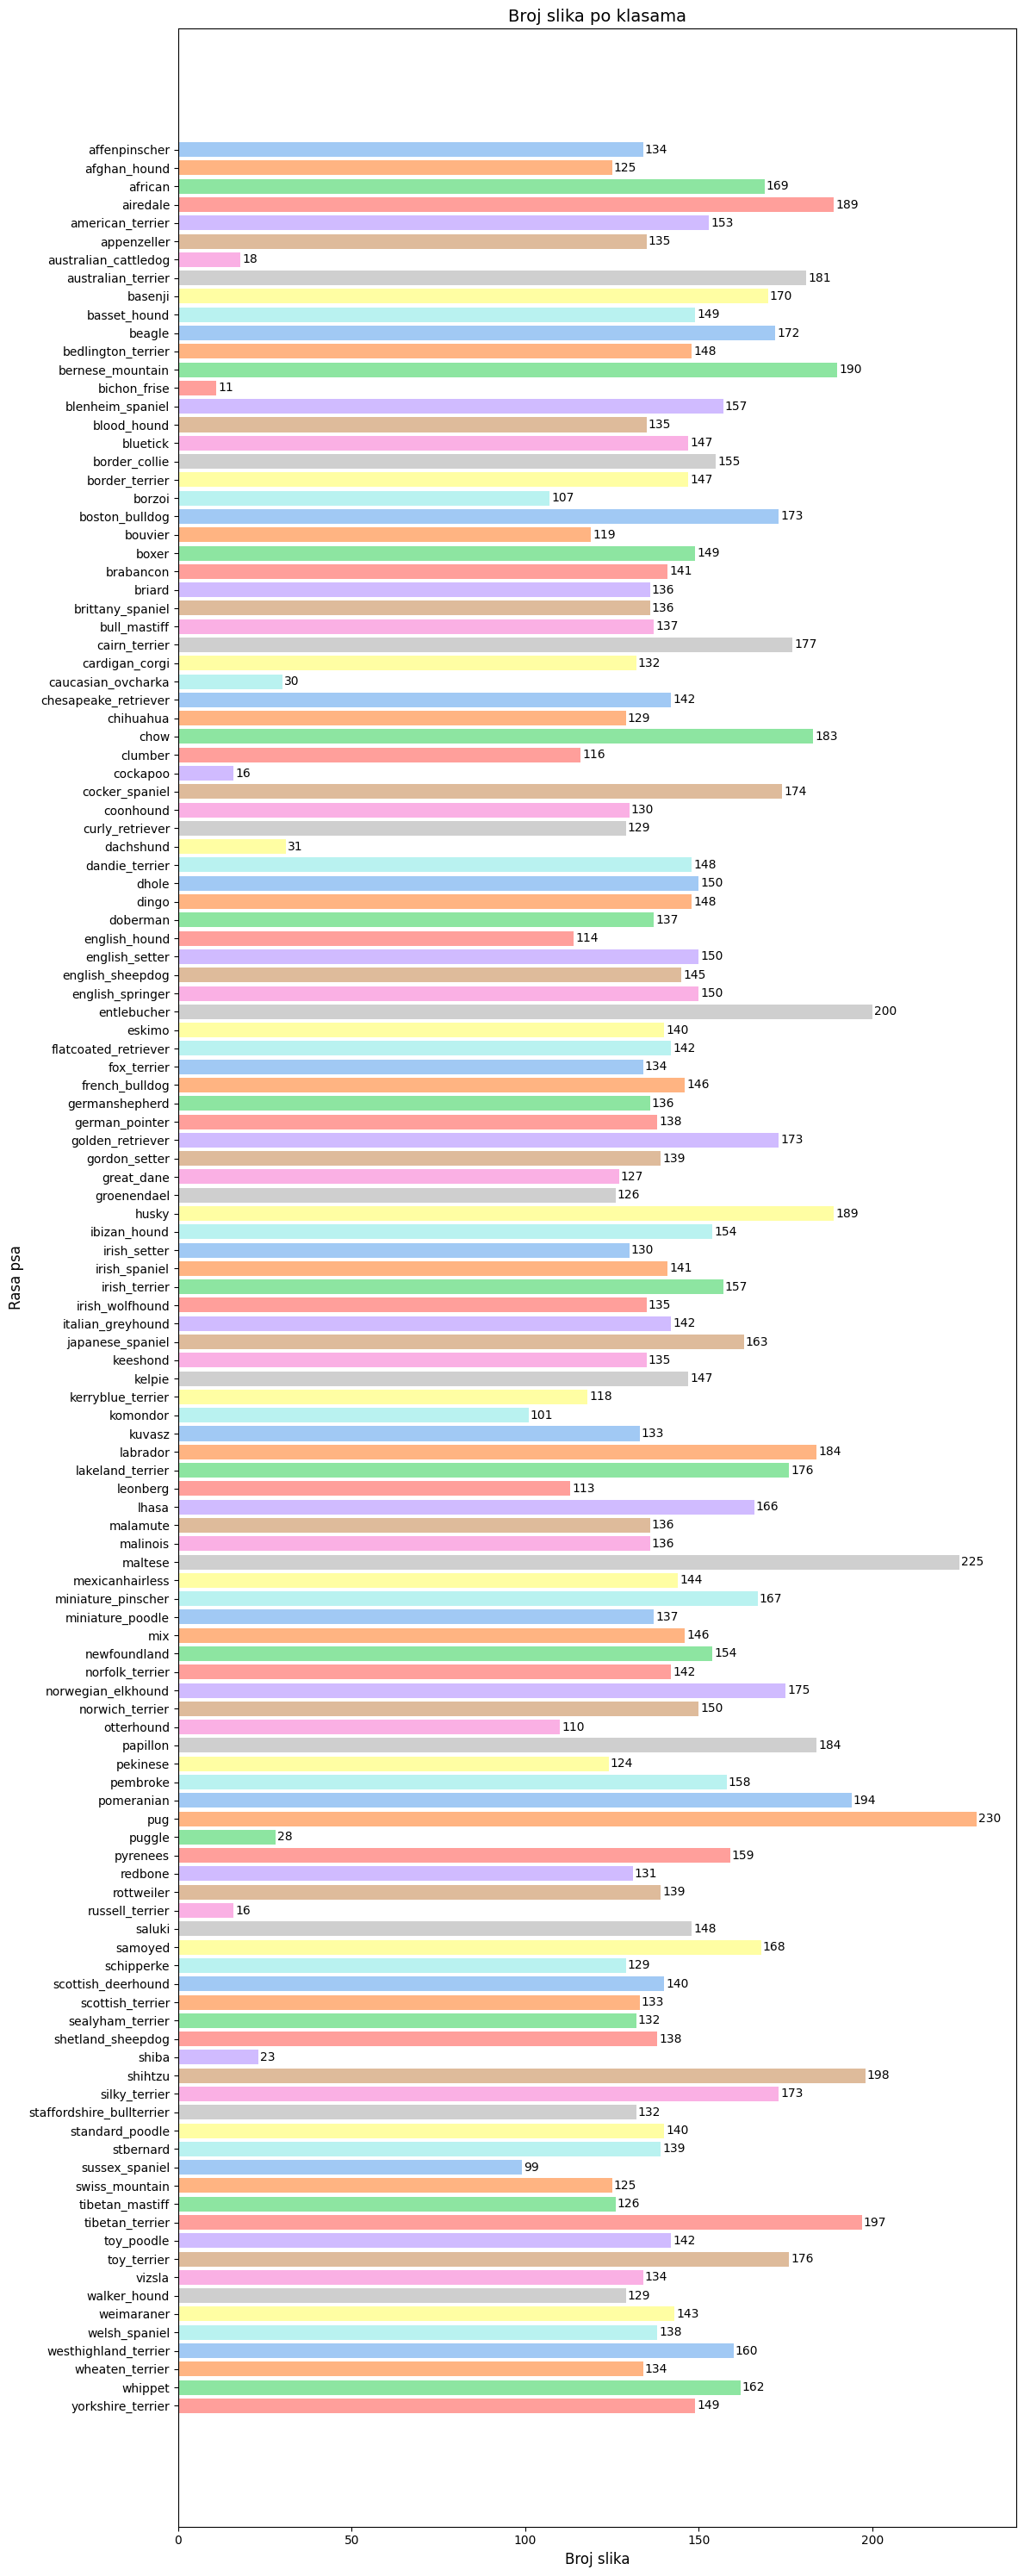

In [245]:
plt.figure(figsize=(12, 30))
colors = sns.color_palette("pastel", len(classes))

bars = plt.barh(class_names, image_per_class, color=colors)
plt.xlabel('Broj slika', fontsize=12)
plt.ylabel('Rasa psa', fontsize=12)
plt.title('Broj slika po klasama', fontsize=14)
plt.gca().invert_yaxis()  # najveći broj gore

# Dodavanje vrednosti pored bara
for bar, count in zip(bars, image_per_class):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, str(count),
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

Sledeći graf prikazuje broj slika po rasama od najvećeg broja slika po klasi do najmanjeg. 

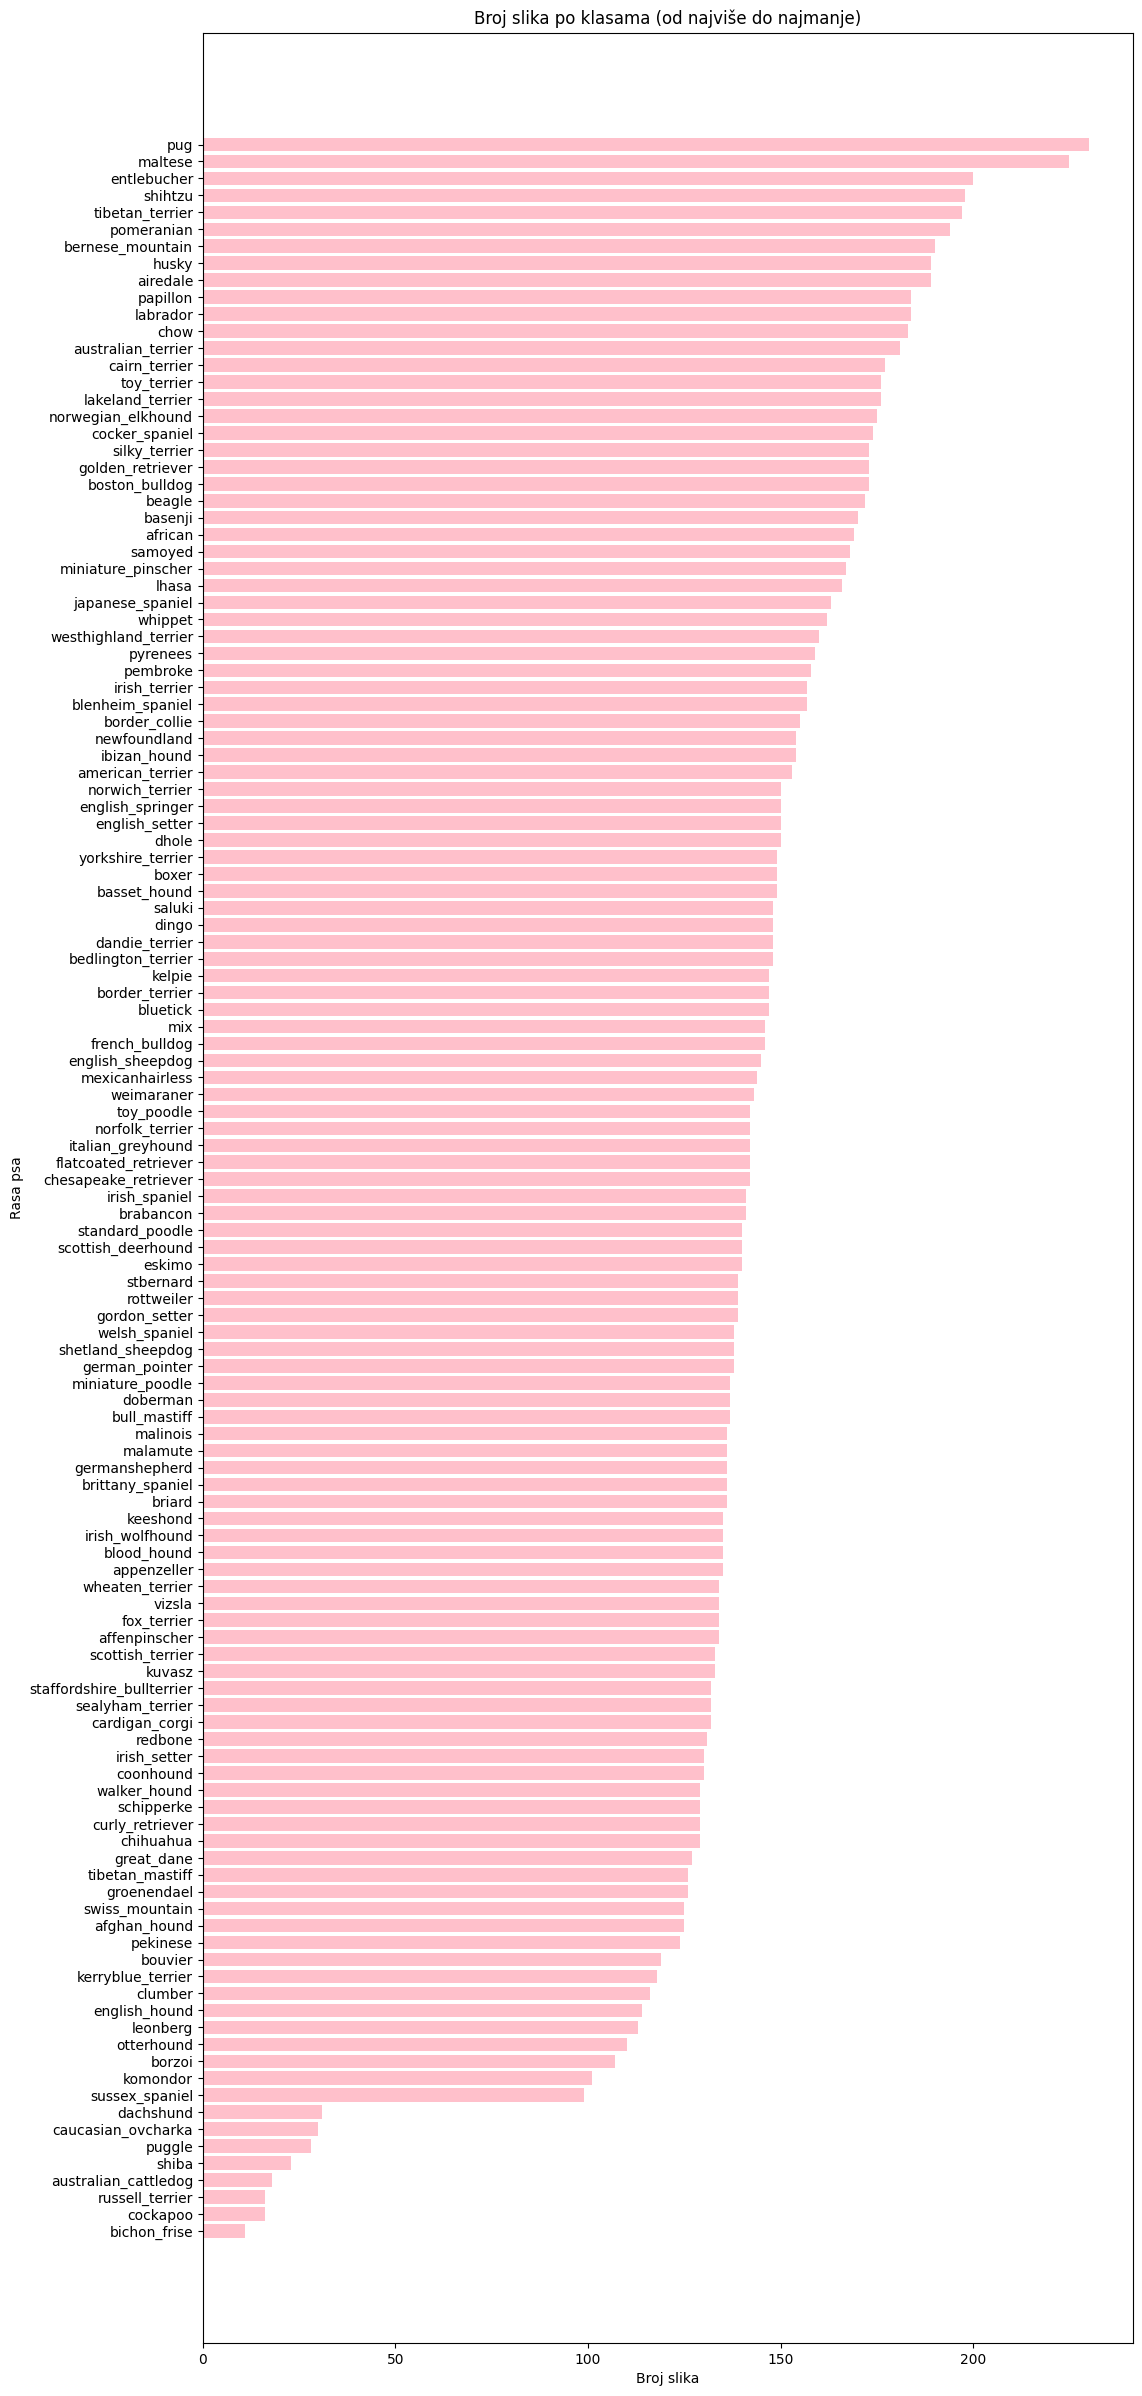

In [38]:

sorted_pairs = sorted(zip(image_per_class, class_names), reverse=True)
sorted_counts, sorted_classes = zip(*sorted_pairs)


plt.figure(figsize=(12,30))
plt.barh(sorted_classes, sorted_counts, color='pink')
plt.xlabel('Broj slika')
plt.ylabel('Rasa psa')
plt.title('Broj slika po klasama (od najviše do najmanje)')
plt.gca().invert_yaxis()  
plt.show()

Precizno određujemo koji je najmanji a koji najveći broj slika po klasama. Na osnovu grafika iznad može se proceniti da veći broj klasa ima najmanji broj slika, pa se ispisuju sve klase sa najvećim i sa najmanjim brojem.  

In [246]:
min_count = min(image_per_class)
max_count = max(image_per_class)

min_classes = [cls.name for cls, count in zip(classes, image_per_class) if count == min_count]
max_classes = [cls.name for cls, count in zip(classes, image_per_class) if count == max_count]

print(f"Folderi sa najmanje slika ({min_count}): {min_classes}")
print(f"Folderi sa najviše slika ({max_count}): {max_classes}")

Folderi sa najmanje slika (11): ['bichon_frise']
Folderi sa najviše slika (230): ['pug']


Ispis klasa sa više od 200 slika:

In [252]:
threshold = 180
classes_above_threshold = [cls.name for cls, count in zip(classes, image_per_class) if count > threshold]

print(f"Folderi sa više od {threshold} slika: {classes_above_threshold}")


Folderi sa više od 180 slika: ['airedale', 'australian_terrier', 'bernese_mountain', 'chow', 'entlebucher', 'husky', 'labrador', 'maltese', 'papillon', 'pomeranian', 'pug', 'shihtzu', 'tibetan_terrier']


Gore navedeni rezultati su nakon brisanja klasa sa manjim brojem slika od 10. 

In [40]:
def filter_classes_by_count(data_dir, min_samples=10):
    """
    Uklanja klase sa manje od min_samples primeraka
    """
    
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            num_samples = len([f for f in os.listdir(class_dir) 
                             if os.path.isfile(os.path.join(class_dir, f))])
            class_counts[class_name] = num_samples
    
    
    removed_count = 0
    for class_name, count in class_counts.items():
        if count < min_samples:
            class_dir = os.path.join(data_dir, class_name)
            shutil.rmtree(class_dir)
            print(f"Obrisana klasa '{class_name}' sa {count} samples")
            removed_count += 1
    
    print(f"Ukupno obrisanih klasa: {removed_count}")
    return class_counts
class_counts = filter_classes_by_count(data_root, min_samples=10)


print("\nPreostale klase:")
for class_name, count in sorted(class_counts.items()):
    if count >= 10:
        print(f"{class_name}: {count} samples")

Ukupno obrisanih klasa: 0

Preostale klase:
affenpinscher: 134 samples
afghan_hound: 125 samples
african: 169 samples
airedale: 189 samples
american_terrier: 153 samples
appenzeller: 135 samples
australian_cattledog: 18 samples
australian_terrier: 181 samples
basenji: 170 samples
basset_hound: 149 samples
beagle: 172 samples
bedlington_terrier: 148 samples
bernese_mountain: 190 samples
bichon_frise: 11 samples
blenheim_spaniel: 157 samples
blood_hound: 135 samples
bluetick: 147 samples
border_collie: 155 samples
border_terrier: 147 samples
borzoi: 107 samples
boston_bulldog: 173 samples
bouvier: 119 samples
boxer: 149 samples
brabancon: 141 samples
briard: 136 samples
brittany_spaniel: 136 samples
bull_mastiff: 137 samples
cairn_terrier: 177 samples
cardigan_corgi: 132 samples
caucasian_ovcharka: 30 samples
chesapeake_retriever: 142 samples
chihuahua: 129 samples
chow: 183 samples
clumber: 116 samples
cockapoo: 16 samples
cocker_spaniel: 174 samples
coonhound: 130 samples
curly_retriev

Klase sa manjim brojem slika su uklonjene prilikom jedne od prethodnih analiza, pa je u ovom i svakom narednom slučaju taj broj 0.

Prikaz podataka (slika), i to po 3 primerka za prvih 5 klasa.

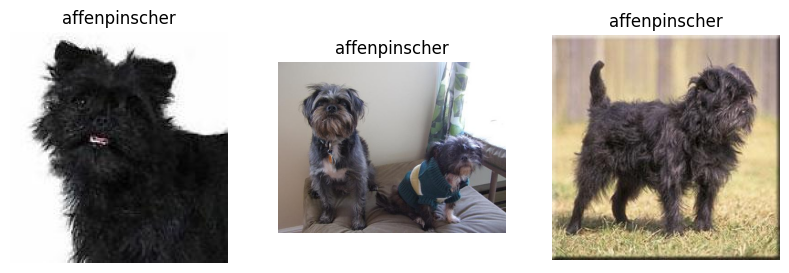

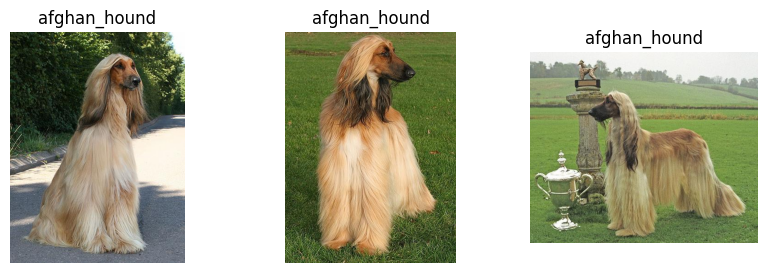

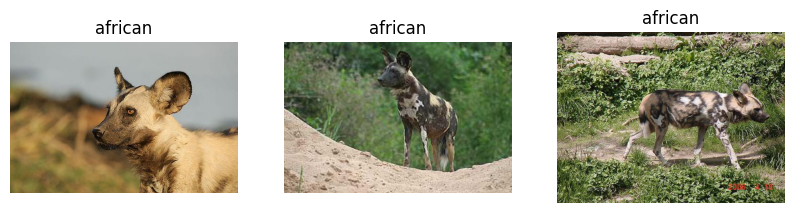

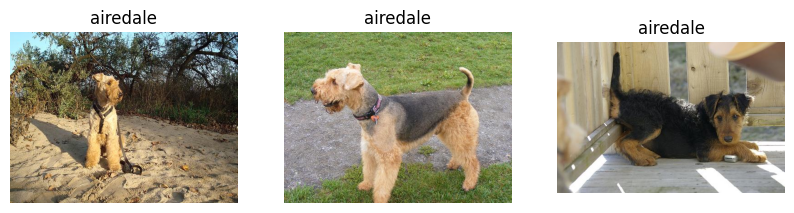

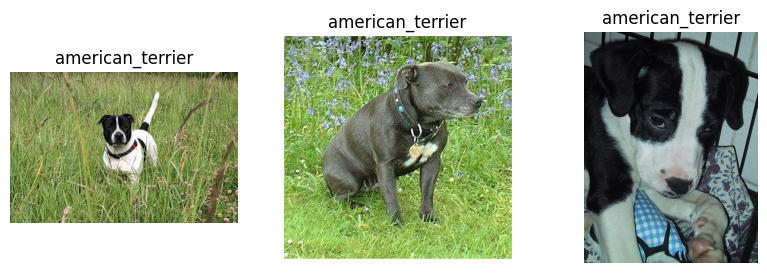

In [41]:
for cls in classes[:5]:
    imgs = list(cls.iterdir())
    random_imgs = random.sample(imgs, min(3, len(imgs)))
    plt.figure(figsize=(10,3))
    for i, img_path in enumerate(random_imgs):
        img = Image.open(img_path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls.name)
    plt.show()

Možemo primetiti da slike nisu istih dimenzija! Taj deo će biti obrađen u narednoj fazi, odnosno u okviru predprocesiranja podataka, a u nastavku če biti analizirane dimenzije slika.

In [254]:
widths, heights = [], []

for cls in classes:
    for img_path in cls.iterdir():
        if img_path.suffix.lower() == '.jpg':
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)



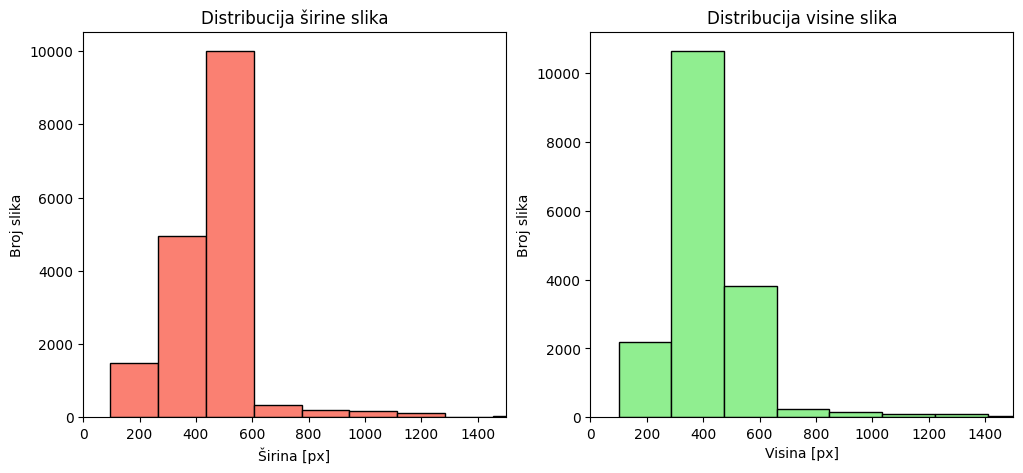

In [258]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30, color='salmon', edgecolor='black')
plt.xlabel('Širina [px]')
plt.ylabel('Broj slika')
plt.title('Distribucija širine slika')
plt.xlim(0, 1500) 

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Visina [px]')
plt.ylabel('Broj slika')
plt.title('Distribucija visine slika')
plt.xlim(0, 1500) 
plt.show()

**Problem**: Veliki broj klasa (>120) a relativno mali broj slika (≈17000). Broj slika je previše mali da bi razvnomerno bio raspoređen na ovaj broj klasa, samim tim smanjuje se šansa da model dobro klasifikuje. 

**Rešenje**:Za treniranje modela izdvojeno je 5 klasa: *pug, husky, maltese, golden_retriever i labrador*. Kriterijum za odabir ovih klasa bila je raznolikost izmedju samih rasa kao i veći broj slika po klasama. Kreira se novi dataset, koji kosirti samo ove klase za dalji rad.

In [247]:
selected_class_names = ["pug", "husky", "maltese", "golden_retriever", "labrador"]
selected_classes = [p for p in classes if p.name in selected_class_names]

print("Broj izabranih rasa:", len(selected_classes))
print("Izabrane klase:", [c.name for c in selected_classes])

Broj izabranih rasa: 5
Izabrane klase: ['golden_retriever', 'husky', 'labrador', 'maltese', 'pug']


In [248]:
images = []
for cls in selected_classes:
    for img_path in cls.glob("*.*"):  # učitava sve slike
        images.append((img_path, cls.name))

print("Ukupno slika za trening:", len(images))

Ukupno slika za trening: 1001


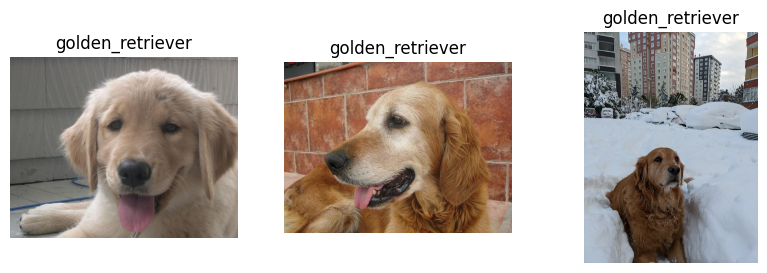

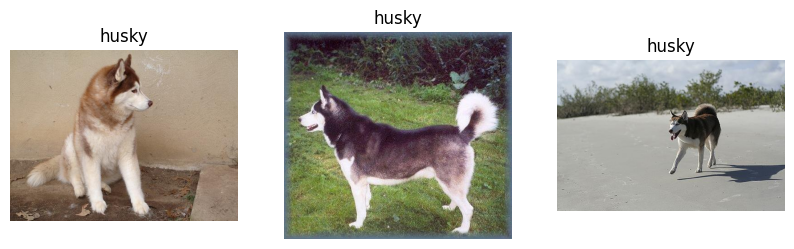

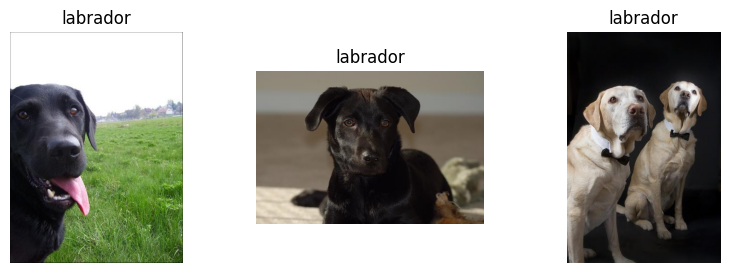

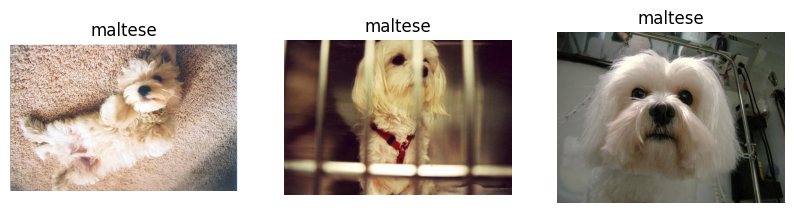

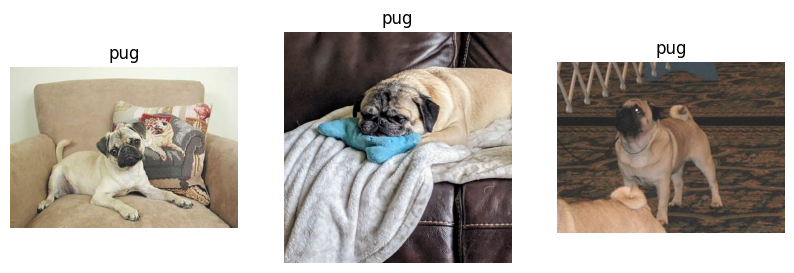

In [249]:
for cls in selected_classes[:5]:
    imgs = list(cls.iterdir())
    random_imgs = random.sample(imgs, min(3, len(imgs)))
    plt.figure(figsize=(10,3))
    for i, img_path in enumerate(random_imgs):
        img = Image.open(img_path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls.name)
    plt.show()

In [259]:
class_counts = {}
for cls in selected_classes:
    image_count = len(list(cls.glob("*.*")))  
    class_counts[cls.name] = image_count

print("Broj slika po klasama:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Broj slika po klasama:
golden_retriever: 173
husky: 189
labrador: 184
maltese: 225
pug: 230


Dublji uvid u ove slike može se dobiti korišćenjem histograma. Posmatranjem histograma slike dobija se intuicija o kontrastu, osvetljenju i raspodeli intenziteta te slike. Histogram se može posmatrati zajedno sa sivom verzijom fotografije da bi se bolje razumela njegova funkcija. 

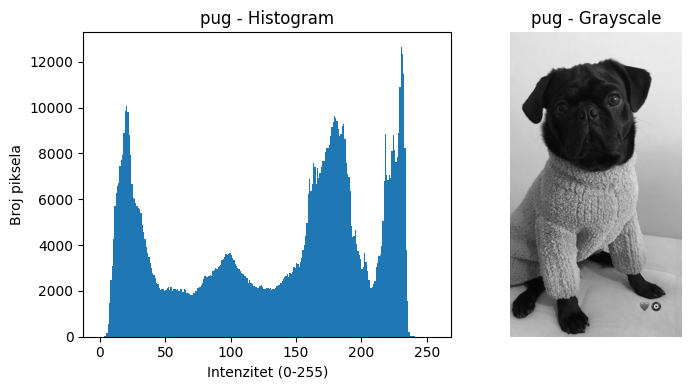

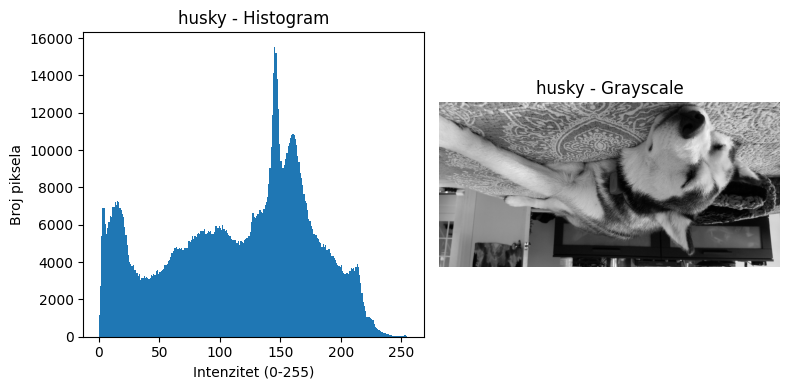

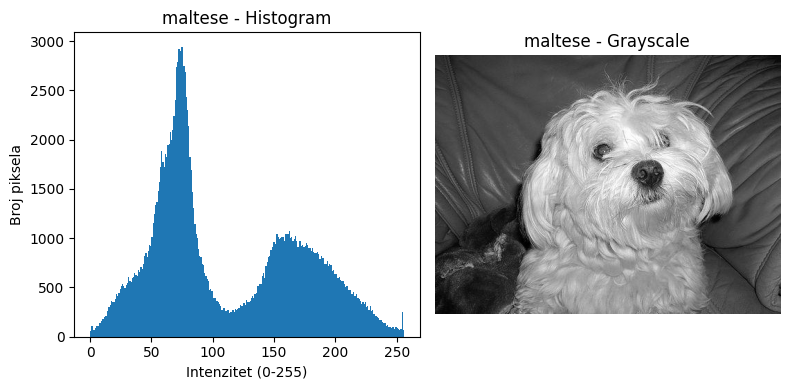

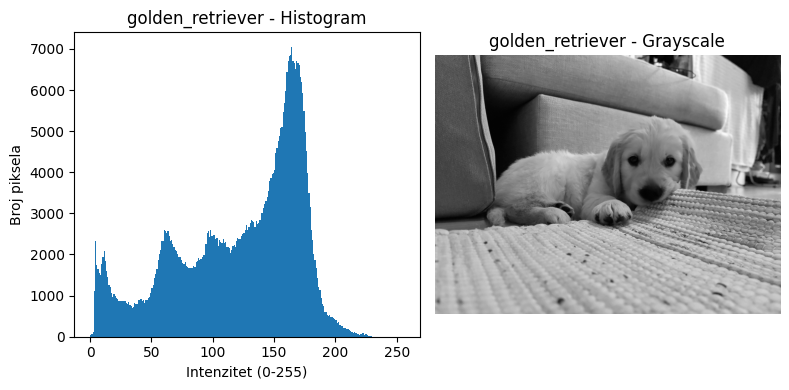

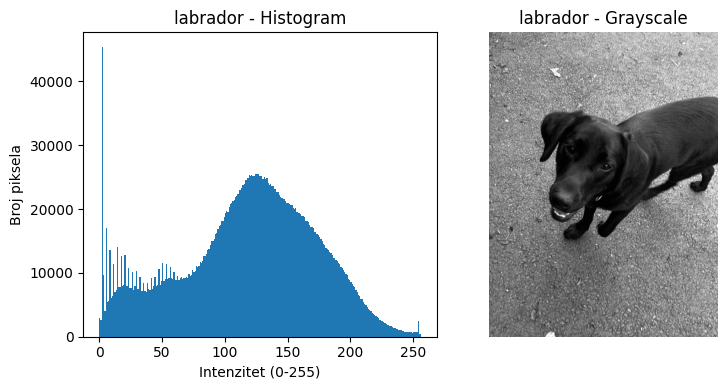

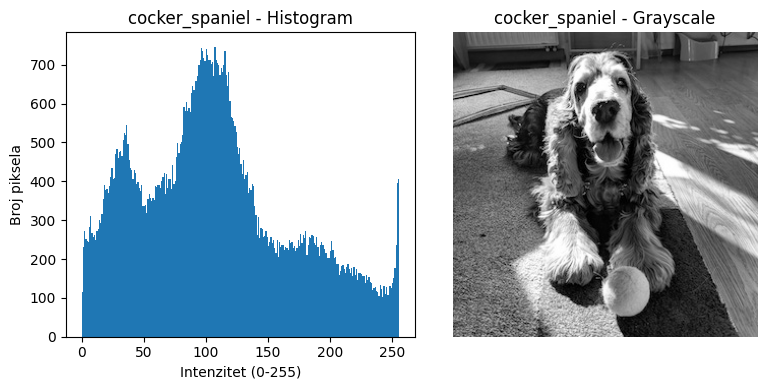

In [48]:
for class_name in selected_class_names:
    class_folder = data_root / class_name
    example_img_path = next(class_folder.glob("*.*"))  # uzima prvu sliku iz klase

    img = cv2.imread(str(example_img_path))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(8, 4))

    # levi subplot: histogram
    plt.subplot(1, 2, 1)
    plt.hist(img_gray.ravel(), bins=256, range=[0, 256])
    plt.title(f"{class_name} - Histogram")
    plt.xlabel("Intenzitet (0-255)")
    plt.ylabel("Broj piksela")

    # desni subplot: grayscale slika
    plt.subplot(1, 2, 2)
    plt.imshow(img_gray, cmap="gray")
    plt.title(f"{class_name} - Grayscale")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

**Zaključak:** 

Kada slika ima ravnotežu svetlih i tamnih delova (ali vrlo malo srednjih tonova), ona će imati U-oblikovani histogram, takav histogram najbolje je prikazan na slici maltezera.

Slika sa mnogo crnih tonova imaće znatno drugačiji tip raspodele, gde najtamniji/crni pikseli zauzimaju veće vrednosti na x-osi, kao na slici labradora

Istraživanje ovih histograma pruža dublji uvid u to kako modeli razlažu slike na piksele radi zadataka prepoznavanja.

Takođe se vrši provera da li postoje duplikati slika. Provera po nazivu slike ne bi imala efekta, jer slike mogu biti duplikati a da imaju različit naziv. Zbog toga je najbolje rešenje <span style="color:pink">heširanje</span> slika. Svaka slika je pretvorena u hash vrednost i poređenjem se može videti da li neka slika daje isti haš (ista slika će dati isti heš -> duplikati).

In [49]:
import hashlib

all_images = []
for cls in selected_classes:
    all_images.extend(cls.glob("*")) 

def file_hash(path):
    hasher = hashlib.md5()
    with open(path, "rb") as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

hashes = {}
duplicates = []

for img in all_images:
    h = file_hash(img)
    if h in hashes:
        duplicates.append((img, hashes[h]))  
    else:
        hashes[h] = img

if duplicates:
    print("Duplikati slika:")
    for dup in duplicates:
        print(dup[0], "<==>", dup[1])
else:
    print("Nema duplikata slika")


Duplikati slika:
data\DogBreedsImageDataset\golden_retriever\golden_retriever_1.jpg <==> data\DogBreedsImageDataset\golden_retriever\golden_retriever_1 - Copy.jpg


U folderu je namerno duplirana slika 'golden_retriever_1.jpg', kako bi se pokazala tačnost ovog rešenja. Slike su duplikati iako im je naziv drugačiji.

### **Faza2**:Pipeline za treniranje, validaciju i testiranje modela

Model će biti treniran nad 5 predefinisanih klasa. Prvo je potrebno izdvojiti te klase tako što će biti kreiran novi dataset.

In [154]:
original_data_dir = Path("data/DogBreedsImageDataset")
filtered_data_dir = Path("data/DogBreedsImageDataset_filtered")
selected_classes = ["pug", "husky", "maltese", "golden_retriever", "labrador"]

filtered_data_dir.mkdir(exist_ok=True)
for cls in selected_classes:
    src = original_data_dir / cls
    dst = filtered_data_dir / cls
    if not dst.exists():
        shutil.copytree(src, dst)

print(f"Dataset filtriran na {len(selected_classes)} klasa i sačuvan u: {filtered_data_dir}")

Dataset filtriran na 5 klasa i sačuvan u: data\DogBreedsImageDataset_filtered


In [156]:
full_dataset = datasets.ImageFolder(filtered_data_dir)
class_names = full_dataset.classes
print(f"Klase u datasetu: {class_names}")

Klase u datasetu: ['golden_retriever', 'husky', 'labrador', 'maltese', 'pug']


Kako ne bi došlo do overfitting-a i loših rezultata prilikom rada modela sa novim slikama, koristi se augmentacija. 

Prvi set transformacija <b style="color:pink">train_transform</b> korisit se za trening set podataka. Na ovaj način veštački se uvećava dataset čineći model otpornijim na overfitting. Postiže se nasumičnim horizontalnim okretanjem slika (model uči da objekat nije vezan samo za jedan položaj), rotiranjem, promenama osvetljenosti ili kontrasta, uzimanjem nasumičnih crop i resize delova. 

Za validaciju i testiranje koristi se drugi set transformacija <b style="color:pink">transform</b> , ovde nema augmentacije, samo Resize, ToTensor i Normalize, jer prilikom testiranja želimo realne podatke bez dodatnih nasumičnih modifikacija. 

In [155]:
from torchvision import transforms

train_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # slučajni crop
    transforms.RandomHorizontalFlip(p=0.2),   # horizontalno okretanje 50% slučajeva
    transforms.RandomRotation(degrees=15),    # rotacija ±15°
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
    transforms.RandomErasing(p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


transform = transforms.Compose([
    transforms.Resize((224, 224)),   # sve slike su iste veličine
    transforms.ToTensor(),          #pretvara sliku u PyTorch tenzor
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

Konačni skup podataka se deli na trening skup i validacioni skup. Test skup je kreiran i nalayi se u data/MyTestSet. Podaci se dele tako da 85% slika pripadne skupu za trening, a ostatak za validacioni skup. Na skup za trening se primenjuju *train_transform* skup transfomacija, a na validacioni *transform* skup. Nakon podele ispisan je broj slika koji se nalazi u svakom skupu.

In [ ]:
from torch.utils.data import random_split, DataLoader

batch_size = 32


train_size = int(0.85 * len(full_dataset))  
val_size = len(full_dataset) - train_size  


train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)


train_dataset.dataset.transform = train_transform

val_dataset.dataset.transform = transform


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")


Train: 850, Val: 151


In [158]:
print("Klase:", full_dataset.classes)
print("Mapiranje klase → label:", full_dataset.class_to_idx)


Klase: ['golden_retriever', 'husky', 'labrador', 'maltese', 'pug']
Mapiranje klase → label: {'golden_retriever': 0, 'husky': 1, 'labrador': 2, 'maltese': 3, 'pug': 4}


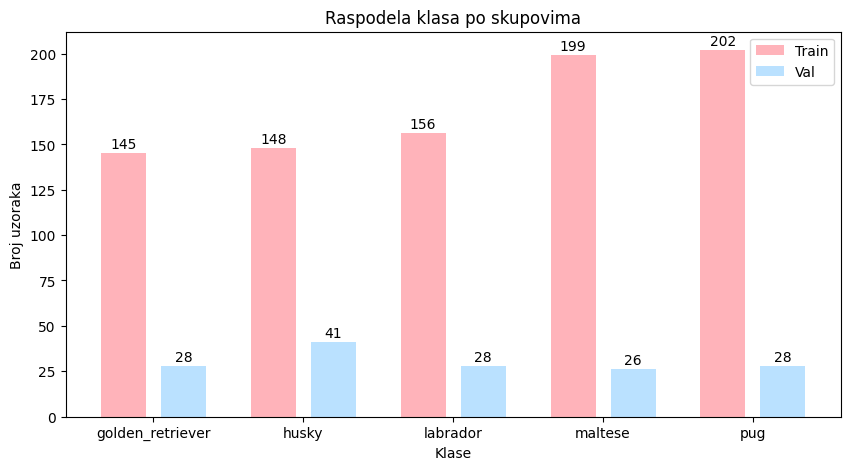

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
val_labels = [val_dataset[i][1] for i in range(len(val_dataset))]

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

classes = sorted(set(train_labels + val_labels))

class_names = full_dataset.classes
classes_names = [class_names[c] for c in classes]

x = range(len(classes))
plt.figure(figsize=(10,5))

train_bars = plt.bar([i - 0.2 for i in x], [train_counts[c] for c in classes], width=0.3, label='Train', color="#FFB3BA")
val_bars = plt.bar([i + 0.2 for i in x], [val_counts[c] for c in classes], width=0.3, label='Val', color="#BAE1FF")

plt.xticks(x, class_names)  
plt.xlabel('Klase')
plt.ylabel('Broj uzoraka')
plt.title('Raspodela klasa po skupovima')
plt.legend()


for bar in train_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

for bar in val_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.show()


Priprema parametara za treniranje: model će tokom treniranja proći 5 puta kroz dataset, stopa učenja je relativno mala vrednost koja pomaže stabilnijem treniranju, i određivanje uređaja koji će PzTorch koristiti za treniranje. 

In [160]:
num_epochs = 5
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")

Koristim uređaj: cpu


**ResNet-18** je duboka konvoluciona neuronska mreža iz porodice Residual Networks (ResNet), dizajnirana za klasifikaciju slika. ResNet-18 se sastoji od 18 slojeva 
(konvolucionih i fully connected slojeva) i često se koristi kao pretrenirani model na ImageNet dataset-u, što omogućava brže i efikasnije treniranje na manjim dataset-ima.
Njegova arhitektura je relativno jednostavna, ali dovoljno moćna za mnoge zadatke prepoznavanja slika. 

ResNet-18 završava sa fully connected (fc) slojem koji originalno izlazi na 1000 klasa (za ImageNet). Ovaj sloj je zamenjen sa len(class_names) kako bi odgovarao broju klasa u datasetu koji se koristi. Kreira se novi linearni sloj sa prilagođenim brojem izlaza. 

Koristi se Adam optimizer je popularan optimizator jer kombinuje prednosti SGD-a sa adaptivnim učenjem po parametru. 

In [161]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

### Trening i validacija

Funkcija **train_one_epoch** služi za treniranje modela kroz jedan prolaz (epoch) kroz ceo trening skup. U njoj se model stavlja u train režim kako bi se aktivirali svi slojevi koji zavise od treniranja (npr. Dropout, BatchNorm). Za svaku batch grupu slika: podaci i label-e se prebacuju na odgovarajući uređaj (CPU ili GPU), računa se izlaz modela, potom gubitak (loss), koji se koristi za računanje gradijenata i ažuriranje težina optimizatorom. Funkcija takođe beleži ukupan gubitak i tačnost na epoch-u, što omogućava praćenje performansi modela tokom treniranja. Na kraju, vraća prosečni gubitak i tačnost za taj epoch.

In [162]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

Funkcija **evaluate** služi za procenjivanje performansi modela na validacionom ili test skupu. Model se stavlja u eval režim, što isključuje slojeve koji zavise od treniranja (kao što su Dropout i BatchNorm) i osigurava konzistentne rezultate. Unutar bloka torch.no_grad() se onemogućava računanje gradijenata, što štedi memoriju i ubrzava evaluaciju. Za svaki batch podataka funkcija računa izlaze modela, gubitak (loss) i broj tačno klasifikovanih primera. Na kraju, vraća prosečni gubitak i tačnost modela na celom dataset-u, što omogućava praćenje koliko dobro model generalizuje na nove podatke.

In [163]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

Sledeći kod predstavlja proces treniranja modela kroz više epoch-a. Za svaku epoch, model se trenira na trening skupu pomoću funkcije train_one_epoch, a zatim se evaluira na validacionom skupu funkcijom evaluate kako bi se pratila tačnost i gubitak. Rezultati se čuvaju u listama radi praćenja napretka, a istovremeno se ispisuju radi pregleda tokom treniranja. Na kraju, težine modela se čuvaju u fajl kako bi se mogle koristiti za kasniju inferencu ili dalje treniranje.

In [164]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model.train()
for epoch in range(num_epochs):
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
save_file(model.state_dict(), "model_weights.safetensors")

Epoch [1/5] | Train Loss: 0.5850 | Train Acc: 0.8118 | Val Loss: 0.1633 | Val Acc: 0.9404
Epoch [2/5] | Train Loss: 0.0714 | Train Acc: 0.9894 | Val Loss: 0.1476 | Val Acc: 0.9470
Epoch [3/5] | Train Loss: 0.0246 | Train Acc: 1.0000 | Val Loss: 0.1215 | Val Acc: 0.9669
Epoch [4/5] | Train Loss: 0.0131 | Train Acc: 0.9976 | Val Loss: 0.1095 | Val Acc: 0.9603
Epoch [5/5] | Train Loss: 0.0091 | Train Acc: 1.0000 | Val Loss: 0.1053 | Val Acc: 0.9603


Rezultati treniranja pokazuju da model brzo uči, jer treningska tačnost već posle prve epoch-e dostiže 81%, a do treće epoch-e čak 100%, dok treningski gubitak opada sa 0.5850 na 0.0246, što ukazuje na efikasno učenje karakteristika slika. Validacioni skup pokazuje da model dobro generalizuje, sa validacionom tačnošću koja raste sa 94% na oko 96% i gubitkom koji se postepeno smanjuje, bez znakova ozbiljne pretreniranosti. Ovi rezultati sugerišu da model brzo savladava osnovne obrasce u podacima i zadržava stabilnu performansu na neviđenim podacima.

Uzimajući u obzir da se koristi ResNet-18 pretreniran na ImageNet-u, ovi rezultati su očekivano dobri i logični. Pretreniran model već poseduje ugrađene reprezentacije osnovnih vizuelnih karakteristika (ivice, teksture, oblici), što omogućava brzo i efikasno prilagođavanje na novi dataset.

Zbog toga treniranje traje relativno kratko (već posle nekoliko epoch-a treningska tačnost dostiže gotovo 100%), dok validaciona tačnost ostaje visoka (~96%), što pokazuje da model uspešno generalizuje na neviđene podatke. Niski treningski gubici i stabilni validacioni gubici sugerišu da ResNet-18 sa prilagođenim fc slojem može efikasno iskoristiti pretrenirane karakteristike i da dataset nije previše izazovan za ovu arhitekturu.

Ove rezultate moguće je vizuelno prikazati pomoću grafova:

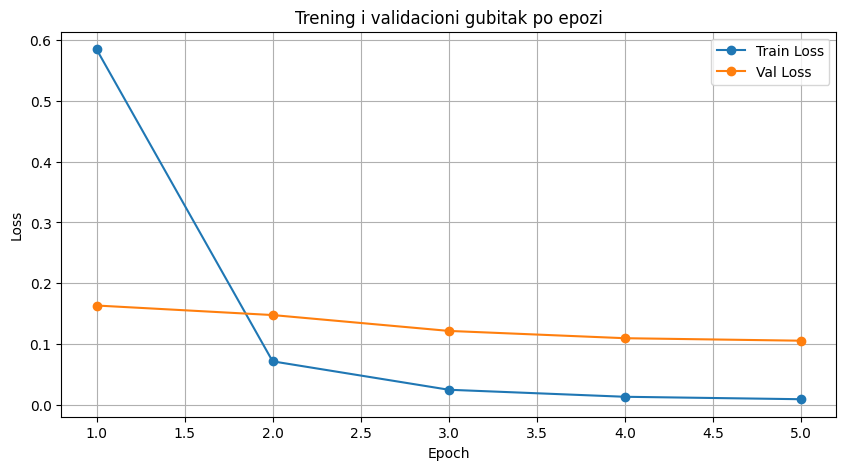

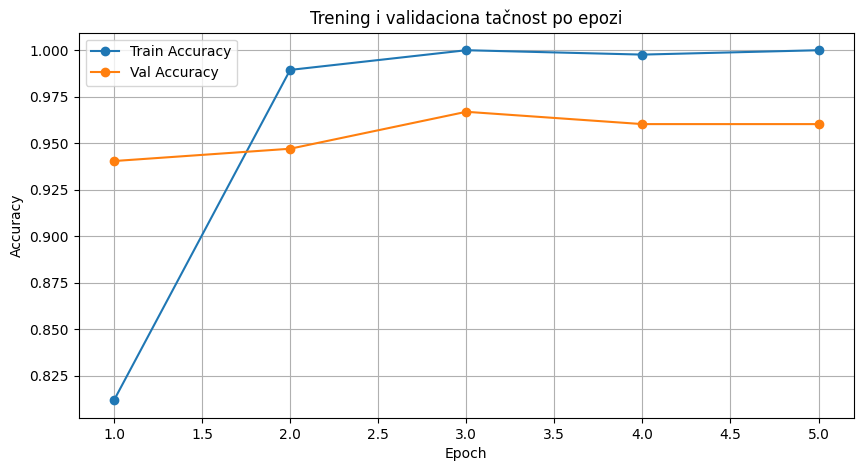

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Trening i validacioni gubitak po epozi')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Trening i validaciona tačnost po epozi')
plt.legend()
plt.grid(True)
plt.show()


### Testiranje

Dalje sledeći kod priprema testni skup podataka za evaluaciju modela. Slike se učitavaju pomoću ImageFolder iz foldera gde je svaka klasa predstavljena posebnim podfolderom, a primenjuju se iste transformacije kao na trening skupu. DataLoader omogućava iteraciju kroz slike u batch-evima po 32, bez mešanja redosleda, dok test_dataset.classes daje listu klasa (npr. rasa pasa) koja se koristi za interpretaciju i vizualizaciju predikcija modela.

In [283]:
test_dataset = ImageFolder("data/MyTestSet", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class_names = test_dataset.classes
print("Test klase:", class_names)


test_labels = [label for _, label in test_dataset]
class_counts = Counter(test_labels)

for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {class_counts[idx]} slika")


Test klase: ['golden_retriever', 'husky', 'labrador', 'maltese', 'pug']
golden_retriever: 10 slika
husky: 10 slika
labrador: 10 slika
maltese: 10 slika
pug: 10 slika


Funkcija test služi za evaluaciju modela na testnom skupu i pravljenje preglednog DataFrame-a sa rezultatima. 

In [284]:
def test(model_weight, test_loader, test_dataset, class_names, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds, all_labels, all_confidences, filenames = [], [], [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            max_prob, idx = torch.max(probs, dim=1)
            
            batch_preds = [i.item() for i in idx]
            all_preds.extend(batch_preds)
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(max_prob.cpu().numpy())
    
    # Imena fajlova
    for i in range(len(test_dataset)):
        filepath, _ = test_dataset.samples[i]
        filenames.append(filepath.split("/")[-1])
    
    # Labels za CSV
    true_labels = [class_names[i] for i in all_labels]
    pred_labels = [class_names[i] for i in all_preds]
    
    df = pd.DataFrame({"Filename": filenames, "True": true_labels, "Predicted": pred_labels, "Confidence": all_confidences})
    
    return df, all_labels, all_preds, all_confidences

Ovaj kod priprema ResNet-18 model sa prilagođenim izlaznim slojem, učitava prethodno sačuvane težine, stavlja model u eval režim i koristi funkciju test da izvrši predikcije na testnom skupu. Rezultat je DataFrame sa imenima fajlova, stvarnim i predikovanim klasama, kao i liste stvarnih i predikovanih labela za dalju analizu performansi modela.

In [285]:
model = models.resnet18(pretrained=False)  # ne učitava pretrained težine
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))  # broj izlaza = broj klasa
model.to(device)

weights = load_file("model_weights.safetensors")
model.load_state_dict(weights)
model.eval()

df, all_labels, all_preds, all_confidences = test(model, test_loader, test_dataset, class_names)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Matricom konfuzije prikazani su rezultati dobijeni evaluacijom modela na testnom skupu, koji jasno pokazuju koliko su predikcije modela tačne za svaku klasu.

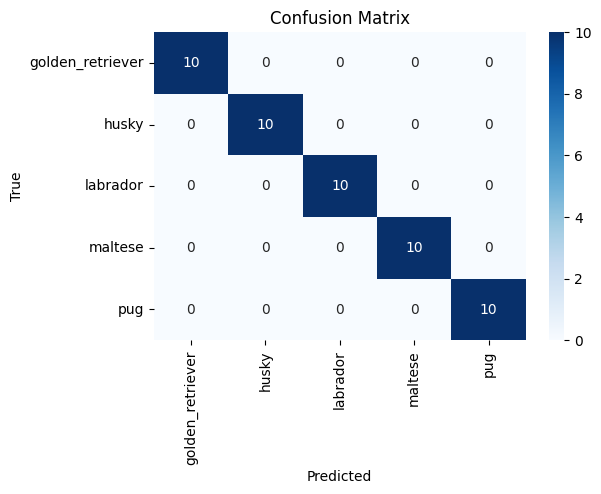

Accuracy: 1.0000


In [286]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Tačnost
accuracy = sum([p==l for p,l in zip(all_preds, all_labels)]) / len(all_labels)
print(f"Accuracy: {accuracy:.4f}")
      

Tumačenjem matrice može se zaključiti da je model dobro istreniran za rad na 5 definisanih klasa. Treba uzeti u obzir da je i test skup relativno mali (po 10 slika za svaku klasu), i da je korišćen pretrenirani ResNet18 model. 

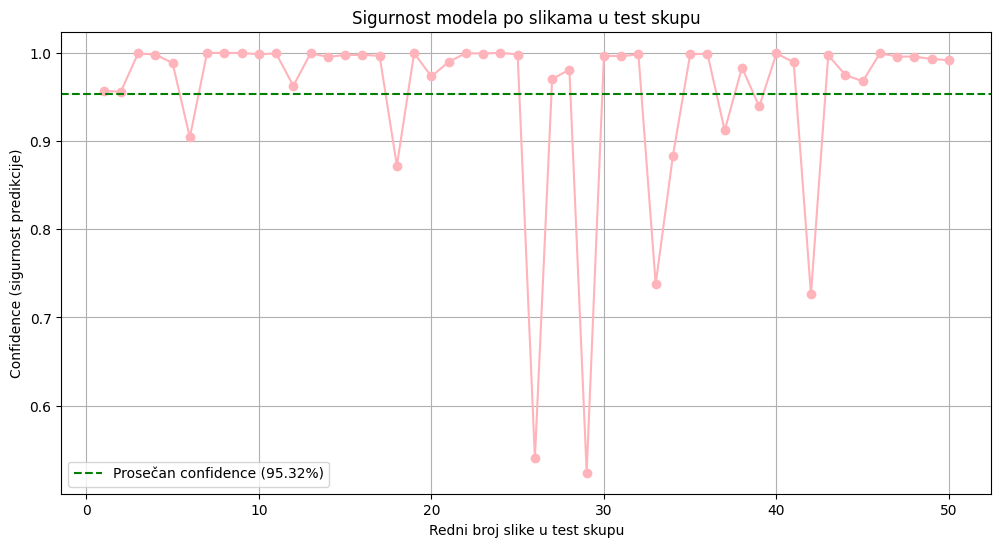

In [279]:
import matplotlib.pyplot as plt

avg_confidence = df['Confidence'].mean()

plt.figure(figsize=(12,6))
plt.plot(range(1, len(df)+1), df['Confidence'], marker='o', color="#FFB3BA", linestyle='-')
plt.axhline(y=avg_confidence, color='green', linestyle='--', label=f'Prosečan confidence ({avg_confidence:.2%})')
plt.xlabel("Redni broj slike u test skupu")
plt.ylabel("Confidence (sigurnost predikcije)")
plt.title("Sigurnost modela po slikama u test skupu")
plt.legend()
plt.grid(True)
plt.show()



Prosečan confidence: 95.32%
Slike sa confidence ispod proseka:
                            Filename              True         Predicted  \
5   MyTestSet\golden_retriever\5.jpg  golden_retriever  golden_retriever   
17             MyTestSet\husky\7.jpg             husky             husky   
25          MyTestSet\labrador\5.jpg          labrador          labrador   
28          MyTestSet\labrador\8.jpg          labrador          labrador   
32           MyTestSet\maltese\2.jpg           maltese           maltese   
33           MyTestSet\maltese\3.jpg           maltese           maltese   
36           MyTestSet\maltese\6.jpg           maltese           maltese   
38           MyTestSet\maltese\8.jpg           maltese           maltese   
41              MyTestSet\pug\10.jpg               pug               pug   

    Confidence  
5     0.903881  
17    0.871940  
25    0.540321  
28    0.524203  
32    0.737940  
33    0.883276  
36    0.911772  
38    0.938914  
41    0.726242  


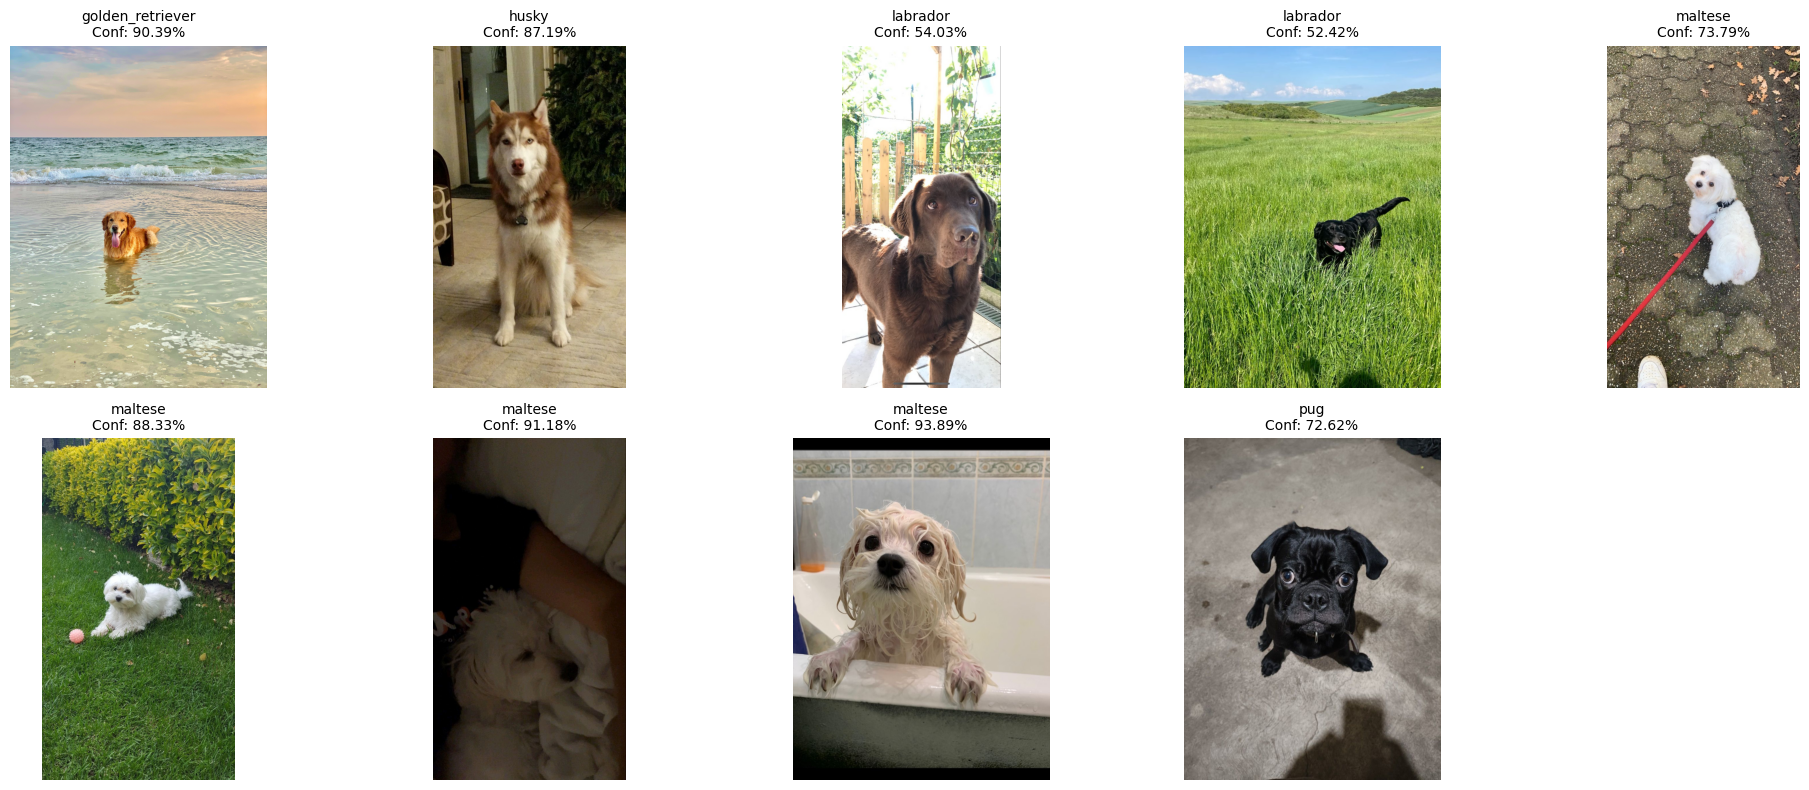

In [282]:
print(f"Prosečan confidence: {avg_confidence:.2%}")

low_conf = df[df['Confidence'] < avg_confidence]

print("Slike sa confidence ispod proseka:")
print(low_conf[['Filename', 'True', 'Predicted', 'Confidence']])

cols = 5
rows = (len(low_conf) + cols - 1) // cols  # automatski broj redova

plt.figure(figsize=(4*cols, 4*rows))

for i, idx in enumerate(low_conf.index):
    img_path, _ = test_dataset.samples[idx]
    image = Image.open(img_path)
    
    plt.subplot(rows, cols, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{df.loc[idx, 'Predicted']}\nConf: {df.loc[idx, 'Confidence']:.2%}", fontsize=10)

plt.tight_layout()
plt.show()


Dog Breed Classifier je model zasnovan na arhitekturi MobileNetV2 koji je fino podešen (fine-tuned) za klasifikaciju pasa u 120 rasa. Model koristi ulazne RGB slike veličine 224x224 piksela i daje verovatnoću za svaku od 120 rasa putem prilagođenog klasifikatora na vrhu MobileNetV2 backbona. Model je treniran transfer učenjem na prilagođenom dataset-u slika pasa i pokazuje dobru preciznost u razlikovanju različitih rasa. Može se koristiti putem Hugging Face Inference API-ja, sa jednostavnom Python funkcijom za predikciju ili integracijom u Django aplikacije preko Hugging Face klijenta. Zbog svojih performansi i različite arhitekture u odnosu na ResNet-18 koji se koristi kao primarni model, ovaj MobileNetV2 model može se koristiti kao drugi model za poređenje performansi u klasifikaciji rasa pasa.

Funkcija test_hf služi za evaluaciju Hugging Face modela na lokalnom test skupu, tako što prolazi kroz sve batch-eve testnih slika, računa logits i verovatnoće, određuje predikovane klase i povezuje ih sa imenima fajlova. Stvarne lokalne klase se mapiraju na Hugging Face klase preko class_mapping, a predikcije se prevode preko model.config.id2label. Na kraju funkcija vraća DataFrame sa imenima fajlova, stvarnim i predikovanima klasama, kao i liste stvarnih i predikovanih labela za analizu performansi.

In [224]:
# mapiranje lokalnih klasa na HuggingFace klase
class_mapping = {
    "maltese": "maltese_dog",
    "labrador": "labrador_retriever",
    "golden_retriever": "golden_retriever",
    "pug": "pug",
    "husky": "siberian_husky"
}

def test_hf(model, processor, test_dataset, class_names, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds, all_labels, filenames = [], [], []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits  # HF modeli vraćaju logits, ne direktno probs
            probs = torch.nn.functional.softmax(logits, dim=1)
            _, idx = torch.max(probs, dim=1)

            all_preds.extend(idx.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # poveži fajlove sa batch-om
            batch_start = batch_idx * test_loader.batch_size
            batch_end = batch_start + len(labels)

            batch_filenames = [
                os.path.basename(test_dataset.samples[i][0])  # "1.jpg"
                for i in range(batch_start, batch_end)
            ]
            filenames.extend(batch_filenames)


    true_labels = [class_mapping[class_names[i]] for i in all_labels]
    pred_labels = [model.config.id2label[i] for i in all_preds]

    df = pd.DataFrame({
        "Filename": filenames,
        "True": true_labels,
        "Predicted": pred_labels
    })
    
    return df, all_labels, all_preds



Učitava se Hugging Face ViT model za klasifikaciju pasa (dog-breeds-multiclass-image-classification-with-vit), priprema ga za korišćenje na odgovarajućem uređaju (CPU ili GPU) i stavlja u eval režim. Zatim se poziva funkcija test_hf koja prolazi kroz testni skup, računa predikcije i mapira lokalne klase na klase modela. Rezultati se čuvaju u CSV fajl predictions_hf.csv sa imenima fajlova, stvarnim i predikcijama, dok print ispisuje potvrdu da su predikcije sačuvane i broj elemenata u listama fajlova, stvarnih i predikovanih labela.

In [ ]:

model_name = "wesleyacheng/dog-breeds-multiclass-image-classification-with-vit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)
model.to(device)
model.eval()

df, all_labels, all_preds = test_hf(model, processor, test_dataset, test_dataset.classes, device=device)
df.to_csv("predictions_hf.csv", index=False)
print("Predikcije sačuvane u predictions_hf.csv")
print(len(filenames), len(all_labels), len(all_preds))

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Predikcije sačuvane u predictions_hf.csv
50 50 50


Kao i za ResNet model, rezultati su prikazani matricom konfuzije:

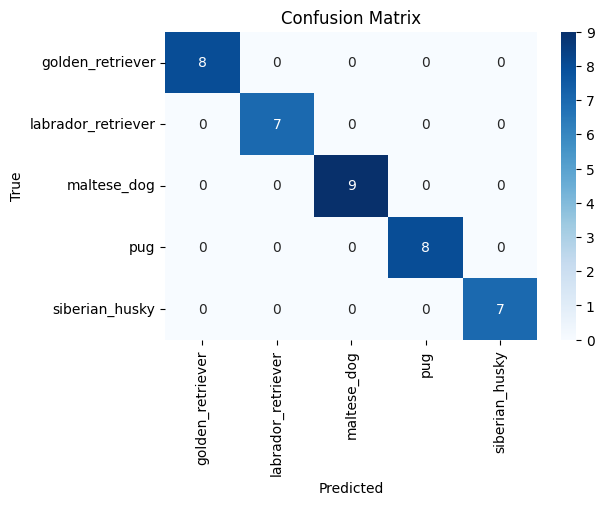

In [226]:
cm = confusion_matrix(df["True"], df["Predicted"], labels=sorted(df["True"].unique()))

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=sorted(df["True"].unique()),
    yticklabels=sorted(df["True"].unique())
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Model je većinu slika tačno predvideo, ali ostale koje nije ne spadaju ni u jednu od 5 klasa koje s etestiraju. Detaljan prikaz nalazi se u fajlu predictions_hf.csv.

In [265]:
df = pd.read_csv("predictions_hf.csv")
print(df.head())
print(df)

  Filename              True         Predicted
0    1.jpg  golden_retriever  golden_retriever
1   10.jpg  golden_retriever  golden_retriever
2    2.jpg  golden_retriever  golden_retriever
3    3.jpg  golden_retriever  golden_retriever
4    4.jpg  golden_retriever  golden_retriever
   Filename                True                  Predicted
0     1.jpg    golden_retriever           golden_retriever
1    10.jpg    golden_retriever           golden_retriever
2     2.jpg    golden_retriever           golden_retriever
3     3.jpg    golden_retriever           golden_retriever
4     4.jpg    golden_retriever           golden_retriever
5     5.jpg    golden_retriever        rhodesian_ridgeback
6     6.jpg    golden_retriever           golden_retriever
7     7.jpg    golden_retriever           golden_retriever
8     8.jpg    golden_retriever           golden_retriever
9     9.jpg    golden_retriever                 pomeranian
10    1.jpg      siberian_husky             siberian_husky
11   10.jp

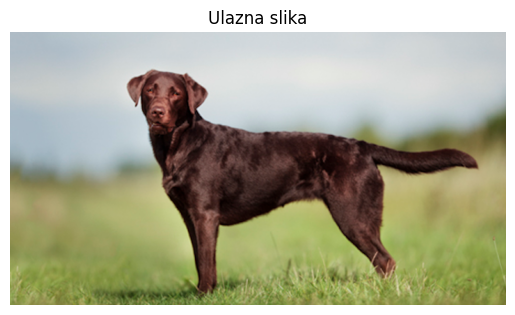

Predikovana klasa: labrador (sigurnost: 96.40%)


In [291]:
#INFORMATIVNO TESTIRANJE MODELA NA URL

import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

model = models.resnet18(pretrained=False)  # ne učitava pretrained težine
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))  # broj izlaza = broj klasa
model.to(device)

weights = load_file("model_weights.safetensors")
model.load_state_dict(weights)
model.eval()

# URL slike
#url = "https://content.lyka.com.au/f/1016262/1104x676/3233341a1e/pug.webp/m/640x427/smart"     #pug
#url = "https://www.zooplus.hr/magazin/wp-content/uploads/2022/01/Stene-maltezera.webp"          #maltese
#url = "https://www.thekennelclub.org.uk/media/1337/spaniel-cocker-standing.jpg?rmode=pad&width=1000&v=1d575070dd23b00"     
#url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRmKr7vkCC7rtS8Ep5WQ-eivIgUf5dUhIwYUw&s"    #unknown 
#url = "https://www.bellaandduke.com/wp-content/uploads/2024/10/A-guide-to-German-Shepherds-characteristics-personality-lifespan-and-more-featured-image.webp"
#url = "https://petreleaf.com/cdn/shop/articles/1_copy_825bc86b-55e3-4272-b4e8-34fe7ecf2c1c.png?v=1747947071"        #labrador
#url = "https://i.pinimg.com/736x/5e/a1/50/5ea150cb976f2a5fc203bcceb5ed3cd5.jpg"   #husky
#url = "https://i.pinimg.com/736x/0a/7d/e8/0a7de8d6ca2f8fd319318823cce046b6.jpg"    #golden retriever
#url = "https://www.akc.org/wp-content/uploads/2017/11/Pug-puppy-standing-in-profile-on-a-white-background.jpg"
url = "https://images.onlinepets.com/uploads/2023/06/Labrador-1.png?auto=format&width=570&height=315&dpr=1.25"

# ------------------------------- Učitavanje slike -------------------------------
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")  # RGB

# Prikaz slike
plt.imshow(img)
plt.axis('off')
plt.title("Ulazna slika")
plt.show()

# ------------------------------- Transformacije -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_tensor = transform(img).unsqueeze(0)  # dodaj batch dimenziju
img_tensor = img_tensor.to(device)

# ------------------------------- Prag poverenja -------------------------------
threshold = 0.8  # 100% sigurno

# ------------------------------- Predikcija -------------------------------
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    probs = F.softmax(outputs, dim=1)  # izračunavanje verovatnoća
    confidence, predicted = torch.max(probs, 1)

    if confidence.item() >= threshold:
        predicted_class = class_names[predicted.item()]
    else:
        predicted_class = "unknown"

print(f"Predikovana klasa: {predicted_class} (sigurnost: {confidence.item()*100:.2f}%)")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

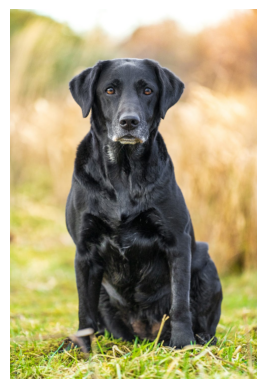

Predviđena klasa: labrador_retriever


In [ ]:
#INFORMATIVNO TESTIRANJE MODELA NA URL

import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification

# ---------------- Parametri ----------------
model_name = "wesleyacheng/dog-breeds-multiclass-image-classification-with-vit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- Učitavanje modela ----------------
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)
model.to(device)
model.eval()

# ---------------- Funkcija za predikciju sa URL ----------------
def predict_and_show_image(url):
    # Preuzimanje slike sa URL-a
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")

    # Prikaz slike
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Priprema slike za model
    inputs = processor(images=img, return_tensors="pt").to(device)

    # Predikcija
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
        predicted_label = model.config.id2label[predicted_class_idx]

    print(f"Predviđena klasa: {predicted_label}")
    return predicted_label

# ---------------- Primer ----------------
#url = "https://content.lyka.com.au/f/1016262/1104x676/3233341a1e/pug.webp/m/640x427/smart"
#url = "https://www.zooplus.hr/magazin/wp-content/uploads/2022/01/Stene-maltezera.webp"
#url = "https://www.akc.org/wp-content/uploads/2017/11/Pug-puppy-standing-in-profile-on-a-white-background.jpg"
#url = "https://www.thekennelclub.org.uk/media/1337/spaniel-cocker-standing.jpg?rmode=pad&width=1000&v=1d575070dd23b00"
#url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRmKr7vkCC7rtS8Ep5WQ-eivIgUf5dUhIwYUw&s"
#url = "https://www.bellaandduke.com/wp-content/uploads/2024/10/A-guide-to-German-Shepherds-characteristics-personality-lifespan-and-more-featured-image.webp"
#url = "https://i.pinimg.com/736x/d7/ee/fc/d7eefcf2c4eaec2299e95fed5edfd383.jpg"
#url = "https://i.pinimg.com/736x/0a/7d/e8/0a7de8d6ca2f8fd319318823cce046b6.jpg"
url = "https://hips.hearstapps.com/hmg-prod/images/labrador-royalty-free-image-1597496746.jpg?resize=980:*"
predicted_class = predict_and_show_image(url)